# Travail sur la ponctualité des trains

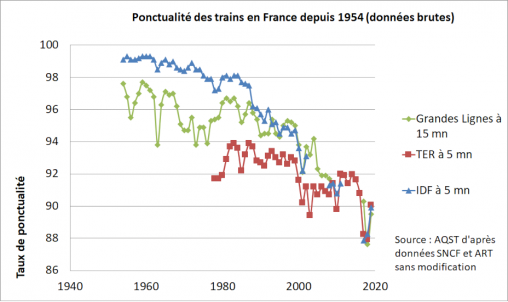

In [342]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt

In [343]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [344]:
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


In [345]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333,52.463054,0.246305,2018,01
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333,36.761905,0.571429,2018,01


In [346]:
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])

(array([   6.,   11.,   75.,  500., 1471., 2769., 1769.,  188.,   24.,
          16.]),
 array([-2.30258509, -1.49669286, -0.69080062,  0.11509162,  0.92098385,
         1.72687609,  2.53276833,  3.33866056,  4.1445528 ,  4.95044504,
         5.75633727]),
 <BarContainer object of 10 artists>)

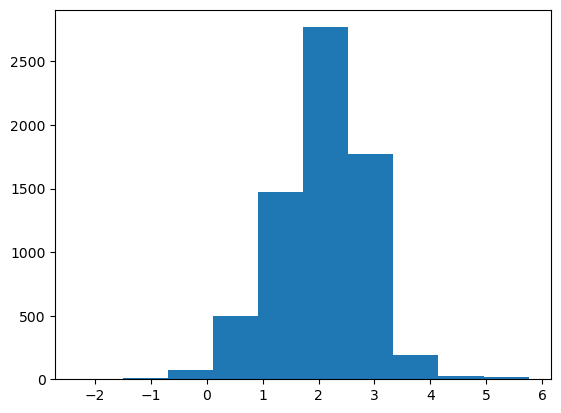

In [347]:
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['retard_moyen_depart']==0].index)
df_retards['log_retard_moyen_depart'] = np.log(df_retards['retard_moyen_depart'])
plt.hist(df_retards['log_retard_moyen_depart'])


In [348]:
df_retards_initial = df_retards
df_retards_initial

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois,log_retard_moyen_depart
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,35.000000,16.666667,16.666667,8.333333,3.333333,52.463054,0.246305,2018,1,2.137707
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,26.666667,21.333333,4.000000,9.333333,1.333333,36.761905,0.571429,2018,1,1.987188
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,23.809524,21.428571,23.809524,9.523810,0.000000,12.727273,0.779221,2018,1,2.123768
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,38.461538,15.384615,19.230769,0.000000,0.000000,14.919355,0.403226,2018,1,2.251434
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,45.614035,19.298246,15.789474,1.754386,1.754386,47.457627,0.847458,2018,1,1.914666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,2.272727,15.909091,22.727273,2.272727,15.909091,11.643836,0.856164,2022,8,2.727661
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,10.204082,26.530612,42.857143,6.122449,12.244898,10.412574,0.000000,2022,8,2.334644
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,8.333333,16.666667,50.000000,8.333333,16.666667,9.580838,0.000000,2022,8,2.528059
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,9.523810,28.571429,23.809524,0.000000,9.523810,28.571429,0.000000,2022,8,1.404269


In [349]:
df_retards = df_retards.groupby(['date'])[['duree_moyenne','log_retard_moyen_depart','prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']].sum()
df_retards.head()


,duree_moyenne,log_retard_moyen_depart,prct_cause_materiel_roulant,prct_cause_infra,prct_cause_gestion_trafic,nb_train_prevu,prct_cause_externe,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
date,,,,,,,,,
2018-01,22137,271.575599,2478.679317,3786.861079,2340.888356,35229,3383.855911,551.631691,358.083645
2018-02,22527,304.815586,2445.393907,2530.044261,2243.836871,32419,5235.303272,422.500272,122.921417
2018-03,22571,273.610808,2751.999829,2478.596045,2541.962919,35458,4105.418780,643.707817,278.314610
2018-04,22016,279.743754,2958.740950,2805.491754,2241.162929,36218,3340.405710,959.695640,394.503017
2018-05,19996,368.968815,2387.350354,1995.982465,1647.073663,35977,3805.545060,716.798272,547.250187


In [359]:
x = df_retards[['log_retard_moyen_depart','prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]
y = df_retards[['duree_moyenne']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8)
xTest

,log_retard_moyen_depart,prct_cause_materiel_roulant,prct_cause_infra,prct_cause_gestion_trafic,nb_train_prevu,prct_cause_externe,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
date,,,,,,,,
2020-12,163.239450,1860.991093,3283.939163,1535.504323,24335,4313.458274,692.368753,313.738394
2021-07,283.646283,2107.198961,2007.866487,1580.389599,34793,2732.707911,1343.866481,1927.970560
2020-01,188.428057,2382.636523,3184.748355,2886.024181,26940,2657.967960,910.108125,278.514857
2021-08,271.648562,2251.334251,1732.522013,1715.503267,34949,2279.647833,1164.274726,2556.717910
2021-11,297.819784,2343.653363,1520.942910,2429.240282,32848,2616.963708,864.315890,2124.883847
2022-08,300.621103,2720.163627,2035.455383,2810.814587,38398,2287.457983,874.364992,1271.743428
2020-05,112.983601,2000.421330,4408.452988,1209.072276,12042,2266.904712,494.150878,220.997816
2020-06,120.125717,2076.838076,3936.604938,1435.175105,21908,2662.439468,886.928618,302.013796
2018-06,376.425058,2175.609263,3438.791246,1742.568975,36120,2953.276792,695.539032,294.214692


In [351]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
reg.coef_
#reg.intercept_

array([ 3.4161035 ,  2.10965388,  1.74420062,  1.35887383, -0.00578466,
        1.58471379,  1.74391042,  1.46846827])

In [352]:
"""
clf = svm.SVC(kernel = 'rbf', C=1) #crée une classe C=1 (parametre d'hyperregularisation C=1 par défaut)
clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C=1))
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTrain)
"""

"\nclf = svm.SVC(kernel = 'rbf', C=1) #crée une classe C=1 (parametre d'hyperregularisation C=1 par défaut)\nclf = make_pipeline(StandardScaler(), SVC(kernel = 'linear', C=1))\nclf.fit(xTrain, yTrain)\nyPred = clf.predict(xTrain)\n"

In [353]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
yPred

array([20553.11409363, 22491.44497682, 20024.44190757, 20193.2008616 ,
       20967.81223729, 19558.51009691, 22512.00211544, 20753.50680468,
       21216.81130196, 22543.48375423, 19597.2187656 , 21079.66437149,
       22628.0237248 , 20264.43982864, 21222.02857146, 21006.232859  ,
       20881.95558191, 20860.32906029, 19729.55255625, 21575.31085517,
       22469.97230088, 22388.52632016, 20396.35642521, 21237.86246487,
       21114.90792029, 20964.07043585, 22727.08003341, 21287.79956046,
       20451.53228942, 20406.77265147, 19931.34877045, 20969.15188812,
       21248.15193067, 20589.80283376, 10414.54676396, 20964.59227396,
       21532.74039436, 22803.42176322, 20971.05488152, 20514.07056936,
       20757.06392303, 18686.01743574, 20844.68046441, 21132.39138067])

In [354]:
print(yTrain)
print(yPred)

[19981 22544 20394 21159 20756 19416 22016 20581 21191 22638 20288 20945
 22137 20428 20597 20864 21288 21065 20425 21574 22561 22571 20753 21283
 21504 20831 22527 21462 20600 20370 19996 21218 20225 20740 10016 20587
 21548 22648 20683 21203 20655 18184 21362 20649]
[20553.11409363 22491.44497682 20024.44190757 20193.2008616
 20967.81223729 19558.51009691 22512.00211544 20753.50680468
 21216.81130196 22543.48375423 19597.2187656  21079.66437149
 22628.0237248  20264.43982864 21222.02857146 21006.232859
 20881.95558191 20860.32906029 19729.55255625 21575.31085517
 22469.97230088 22388.52632016 20396.35642521 21237.86246487
 21114.90792029 20964.07043585 22727.08003341 21287.79956046
 20451.53228942 20406.77265147 19931.34877045 20969.15188812
 21248.15193067 20589.80283376 10414.54676396 20964.59227396
 21532.74039436 22803.42176322 20971.05488152 20514.07056936
 20757.06392303 18686.01743574 20844.68046441 21132.39138067]


In [355]:
#on regarde si le score est satisfaisant
reg.score(xTrain, yTrain)

0.9555681990156911

In [356]:
epsilon = yTrain - yPred
epsilon

array([ -572.11409363,    52.55502318,   369.55809243,   965.7991384 ,
        -211.81223729,  -142.51009691,  -496.00211544,  -172.50680468,
         -25.81130196,    94.51624577,   690.7812344 ,  -134.66437149,
        -491.0237248 ,   163.56017136,  -625.02857146,  -142.232859  ,
         406.04441809,   204.67093971,   695.44744375,    -1.31085517,
          91.02769912,   182.47367984,   356.64357479,    45.13753513,
         389.09207971,  -133.07043585,  -200.08003341,   174.20043954,
         148.46771058,   -36.77265147,    64.65122955,   248.84811188,
       -1023.15193067,   150.19716624,  -398.54676396,  -377.59227396,
          15.25960564,  -155.42176322,  -288.05488152,   688.92943064,
        -102.06392303,  -502.01743574,   517.31953559,  -483.39138067])

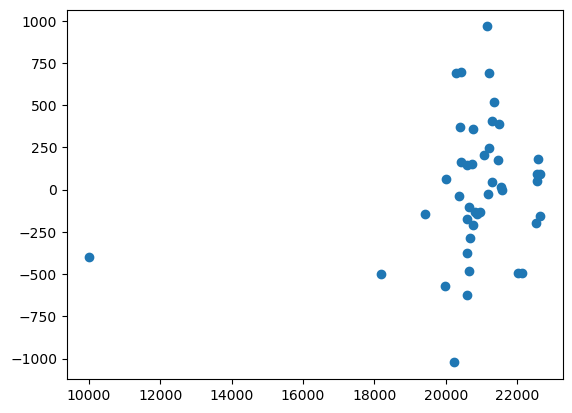

In [357]:
plt.scatter(yTrain, epsilon)

In [363]:
url_surete = "https://ressources.data.sncf.com/api/v2/catalog/datasets/indicateurs-mensuels-de-surete-depuis-janvier-2015/exports/json?limit=-1&offset=0&timezone=UTC"

surete = requests.get(url_surete)
wb_surete = surete.json()

df_surete = pd.DataFrame(wb_surete)
df_surete

,date,nombre_d_atteintes_physiques_toute_victime,nombre_atteintes_verbales_clients,nombre_vols_tire_client,nombre_vols_prejudice_sncf,nombre_vol_metaux,nombre_incivilites,nombre_intrusions_ligne_batiments,nombre_d_activites_illicites,nombre_traversees_voie,nombre_franchissements_cab,nombre_minutes_perdues_irregularite_actes_malveillance,empty1
0,2015-04-01,465.0,55.0,341.0,272.0,149.0,3911.0,1195.0,638.0,669.0,718.0,88840.0,None
1,2016-02-01,489.0,83.0,367.0,187.0,75.0,5800.0,1027.0,965.0,533.0,852.0,77107.0,None
2,2016-09-01,483.0,85.0,299.0,129.0,60.0,4818.0,1075.0,889.0,624.0,723.0,120204.0,None
3,2015-05-01,481.0,72.0,335.0,298.0,167.0,4711.0,1116.0,735.0,686.0,1002.0,59849.0,None
4,2016-05-01,552.0,84.0,338.0,200.0,82.0,5137.0,1430.0,794.0,589.0,958.0,114170.0,None
5,2015-02-01,475.0,70.0,284.0,265.0,136.0,4070.0,843.0,625.0,505.0,643.0,71609.0,ACO
6,2015-09-01,427.0,80.0,340.0,204.0,91.0,4575.0,1174.0,661.0,671.0,994.0,69529.0,None
7,2015-01-01,473.0,69.0,361.0,246.0,124.0,4169.0,811.0,608.0,450.0,698.0,92567.0,None
8,2015-03-01,554.0,59.0,369.0,275.0,147.0,4529.0,1114.0,739.0,705.0,812.0,85457.0,None
9,2016-07-01,540.0,80.0,355.0,193.0,53.0,4576.0,1187.0,796.0,546.0,784.0,133917.0,None


In [364]:
df_surete = df_surete.groupby(['date'])[['nombre_vols_prejudice_sncf','nombre_intrusions_ligne_batiments','nombre_traversees_voie','nombre_franchissements_cab']].sum()
df_surete.head()

,nombre_vols_prejudice_sncf,nombre_intrusions_ligne_batiments,nombre_traversees_voie,nombre_franchissements_cab
date,,,,
2015-01-01,246.0,811.0,450.0,698.0
2015-02-01,265.0,843.0,505.0,643.0
2015-03-01,275.0,1114.0,705.0,812.0
2015-04-01,272.0,1195.0,669.0,718.0
2015-05-01,298.0,1116.0,686.0,1002.0
